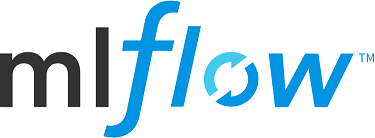

## MLflow Tracking

In this tutorial we will:
1.   Run an interface so we can keep track of all the model runs we perform during the Machine Learning lifecycle.
2. Create one experiment with a public dataset.
3. Run different models with different parameters and log the results in MLflow.
4. Retrieve models trained by different people and compare them.
5. Use these models to predict some data.



In [ ]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

### 1. MLFlow UI (interface)

Install mlflow and pyngrok

In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 10.9 MB/s eta 0

In [ ]:
import mlflow
from pyngrok import ngrok

Get a free account at: https://dashboard.ngrok.com/auth

Set your token: NGROK_AUTH_TOKEN

In [ ]:
# NGROK_AUTH_TOKEN = "******************** YOUR CODE HERE ********************"
NGROK_AUTH_TOKEN = "1tTzdAo2koQUEuOrDc62SvmX94Z_7MFUJos8rB4GXKJFyxRNc"

In [ ]:
# Run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken
# Get your authtoken from https://dashboard.ngrok.com/auth
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("Your MLflow Tracking UI is now live at:", ngrok_tunnel.public_url)

Your MLflow Tracking UI is now live at: https://413d-35-185-112-39.ngrok.io


Go to the URL that returned the previous cell of code, here you can see the MLFlow UI.

### 2. Dataset and experiment

Load the data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(path="boston_housing.npz", test_split=0.2, seed=113)

57026/57026 [==============================] - 0s 0us/step


In [ ]:
x_train.shape, x_test.shape

((404, 13), (102, 13))

Create a new experiment that will encapsulate all the model runs. 
**After running this line, check the MLflow interface!**

In [ ]:
mlflow.set_experiment('Boston Housing')

2023/02/14 17:39:30 INFO mlflow.tracking.fluent: Experiment with name 'Boston Housing' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/581894222607587043', creation_time=1676396370203, experiment_id='581894222607587043', last_update_time=1676396370203, lifecycle_stage='active', name='Boston Housing', tags={}>

Define a function to create some metrics. We will use them to compare the performance of the models on the test set

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

Define a function to plot the real values and the predictions. This function will also push the figure to mlflow.

In [ ]:
def plot_real_vs_prediction(actual, pred):
  # Create a new figure
  fig = plt.figure()

  # Plot the real values and the predictions as two different lines
  plt.plot(actual, label='real')
  plt.plot(pred, label='predictions')

  # Set names and activate the legend
  plt.ylabel('Price')
  plt.xlabel('Sample')
  plt.title('Real vs Prediction')
  plt.legend(loc='lower right')

  # Save the figure to mlflow
  mlflow.log_figure(fig, 'my_figure.png')

  # Close the figure so it is not displayed in the output cell
  plt.close(fig)

### 3. Run a model (GradientBoostingRegressor) with different parameters

Create the model with some hyperparameters and train it using them. Then, evaluate the results on the test data and report the metrics

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

def train_model(x, y, xt, yt, learning_rate=0.1, n_estimators=100, max_depth=3):
  
  # Start to log an experiment
  # A name can be set to distinguish the experiments: run_name='myname'
  with mlflow.start_run():

    print(f'Starting experiment with learning_rate={learning_rate}, n_estimators={n_estimators}, max_depth={max_depth}')

    # Log the parameters we will use to create the model to MLFlow
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Create the model using the parameters
    model = GradientBoostingRegressor(loss='squared_error', 
                                      learning_rate=learning_rate, 
                                      n_estimators=n_estimators, 
                                      max_depth=max_depth)

    # Fit the model to the data
    model.fit(x, y)

    # Predict the test data
    yp = model.predict(xt)
  
    # Check the metrics (real vs predicted)
    rmse_test, mae_test, r2_test = eval_metrics(yt, yp)

    # Log the metrics to MLFlow
    mlflow.log_metric("rmse", rmse_test)
    mlflow.log_metric("mae", mae_test)
    mlflow.log_metric("r2", r2_test)

    # Create a figure with the pred vs actual and log it to mlflow
    plot_real_vs_prediction(yt, yp)

In [ ]:
for lr, ne, md in [(0.01, 200, 2), (0.001, 100, 3), (0.1, 300, 2), (0.1, 500, 2), (0.1, 100, 5), (0.1, 100, 3)]:
  train_model(x_train, y_train, x_test, y_test, learning_rate=lr, n_estimators=ne, max_depth=md)

Starting experiment with learning_rate=0.01, n_estimators=200, max_depth=2
Starting experiment with learning_rate=0.001, n_estimators=100, max_depth=3
Starting experiment with learning_rate=0.1, n_estimators=300, max_depth=2
Starting experiment with learning_rate=0.1, n_estimators=500, max_depth=2
Starting experiment with learning_rate=0.1, n_estimators=100, max_depth=5
Starting experiment with learning_rate=0.1, n_estimators=100, max_depth=3


Check the MLflow interface! Your runs should be registered

## MLflow Projects

We want to compare the solutions of different persons that uploaded their code to GitHub. Let's run their models.

In [ ]:
mlflow.set_experiment('Boston Housing Comparison')

2023/02/14 17:52:04 INFO mlflow.tracking.fluent: Experiment with name 'Boston Housing Comparison' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/635403632802004346', creation_time=1676397124246, experiment_id='635403632802004346', last_update_time=1676397124246, lifecycle_stage='active', name='Boston Housing Comparison', tags={}>

In [ ]:
mlflow.run("https://github.com/perecasxiru/boston_simpleNN", env_manager='local', experiment_name='Boston Housing Comparison')
mlflow.run("https://github.com/perecasxiru/boston_gbt", env_manager='local', experiment_name='Boston Housing Comparison')

2023/02/14 17:52:55 INFO mlflow.projects.utils: === Fetching project from https://github.com/perecasxiru/boston_simpleNN into /tmp/tmpywawijw7 ===
2023/02/14 17:52:56 INFO mlflow.projects.utils: Fetched 'main' branch
2023/02/14 17:52:56 INFO mlflow.projects.utils: === Created directory /tmp/tmp_83z9er5 for downloading remote URIs passed to arguments of type 'path' ===
2023/02/14 17:52:56 INFO mlflow.projects.backend.local: === Running command 'python main.py --layers 3 --neurons 128 --dropout 0.1' in run with ID '138d81d6e978418bbdef6db9096fde43' === 
2023/02/14 17:53:19 INFO mlflow.projects: === Run (ID '138d81d6e978418bbdef6db9096fde43') succeeded ===
2023/02/14 17:53:19 INFO mlflow.projects.utils: === Fetching project from https://github.com/perecasxiru/boston_gbt into /tmp/tmp9ewnqomw ===
2023/02/14 17:53:20 INFO mlflow.projects.utils: Fetched 'main' branch
2023/02/14 17:53:20 INFO mlflow.projects.utils: === Created directory /tmp/tmpvf6us76d for downloading remote URIs passed to a

If we now check the UI, two new runs appeared under a new experiment. We can check the results but also the models.

**What parameters does each model accept?**

We can also query the experiment to see the values as a pandas dataframe.
Check that you have two finished runs with a lot of imformation.

In [ ]:
experiment = mlflow.get_experiment_by_name('Boston Housing Comparison')
experiment_id = experiment.experiment_id

df = mlflow.search_runs([experiment_id])
df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse,metrics.r2,metrics.mae,params.learning_rate,...,tags.mlflow.project.entryPoint,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.git.commit,tags.mlflow.runName,tags.mlflow.source.git.repoURL,tags.mlflow.gitRepoURL,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.project.backend
0,30dde5d45a4346b4916946729f8e5584,635403632802004346,FINISHED,file:///content/mlruns/635403632802004346/30dd...,2023-02-14 17:53:20.317000+00:00,2023-02-14 17:53:31.460000+00:00,3.551338,0.848493,2.339357,0.1,...,main,"[{""run_id"": ""30dde5d45a4346b4916946729f8e5584""...",root,cfe091b173d0b38cabd6c2976328450ccfb7db66,worried-snake-350,https://github.com/perecasxiru/boston_gbt,https://github.com/perecasxiru/boston_gbt,PROJECT,https://github.com/perecasxiru/boston_gbt,local
1,138d81d6e978418bbdef6db9096fde43,635403632802004346,FINISHED,file:///content/mlruns/635403632802004346/138d...,2023-02-14 17:52:56.622000+00:00,2023-02-14 17:53:19.759000+00:00,8.679813,0.094958,6.190399,None,...,main,"[{""run_id"": ""138d81d6e978418bbdef6db9096fde43""...",root,ba283b920d9948af69ef9179a19c7b43e334b3d8,placid-crab-118,https://github.com/perecasxiru/boston_simpleNN,https://github.com/perecasxiru/boston_simpleNN,PROJECT,https://github.com/perecasxiru/boston_simpleNN,local


## MLflow Models
### 1. How to use a model

Now we can try to predict some data using the models

In [ ]:
data = [[0.01311,90,1.22,0,0.403,7.249,21.9,8.6966,5,226,17.9,395.93,4.81],
        [0.14103,0,13.92,0,0.437,5.79,58,6.32,4,289,16,396.9,15.84],
        [11.5779,0,18.1,0,0.7,5.036,97,1.77,24,666,20.2,396.9,25.68]]

First model: sklearn

In [ ]:
run_id = df.loc[0, 'run_id']

In [ ]:
run_id

'30dde5d45a4346b4916946729f8e5584'

In [ ]:
import mlflow
logged_model = f'runs:/{run_id}/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(data))

array([34.25224951, 19.57403943, 11.38005657])

Second model: keras

In [ ]:
run_id = df.loc[1, 'run_id']

In [ ]:
import mlflow
logged_model = f'runs:/{run_id}/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(data))

/usr/local/lib/python3.8/dist-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


1/1 [==============================] - 0s 137ms/step


,0
0,34.487358
1,21.112543
2,14.980490


### 2. How to save a model

In [ ]:
mlflow.set_experiment('Boston Housing Models')

2023/02/14 18:15:59 INFO mlflow.tracking.fluent: Experiment with name 'Boston Housing Models' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/460777972038033568', creation_time=1676398559218, experiment_id='460777972038033568', last_update_time=1676398559218, lifecycle_stage='active', name='Boston Housing Models', tags={}>

There are two different ways to log (save) the models:
- Calling the **log_model** function explicitly
- Activating the **autolog** 

### 2.1 Calling the log_function explicitly

In [ ]:
import mlflow.sklearn

with mlflow.start_run(run_name='explicit_call'):
  model = GradientBoostingRegressor(loss='squared_error', 
                                        learning_rate=0.1, 
                                        n_estimators=100, 
                                        max_depth=3)
  model.fit(x_train, y_train)
  mlflow.sklearn.log_model(model, 'model_explicit')

### 2.2 Activating the autolog
If you had to remember only one thing from this entire class, it would be this...

``mlflow.sklearn.autolog()``

With this single line at the beginning of the execution of the whole notebook, we can forget about registering the metrics, the parameters, the model... MLflow does it for us!



In [ ]:
import mlflow.sklearn
mlflow.sklearn.autolog()

model = GradientBoostingRegressor(loss='squared_error', 
                                      learning_rate=0.1, 
                                      n_estimators=200, 
                                      max_depth=5)
model.fit(x_train, y_train)

2023/02/14 18:19:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2490268897c240438cda968f6b79c595', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


GradientBoostingRegressor(max_depth=5, n_estimators=200)

Now we can also evaluate the model with its runID:

In [ ]:
run_id = '2407d4e2bb424fd5b905744711392249'

In [ ]:
import mlflow
# logged_model = '*************** COPY THE CODE YOU WILL FIND IN THE UI *****************'
logged_model = f'runs:/{run_id}/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(data))

array([34.69240195, 20.21910244,  9.95058254])

In [ ]:
mlflow.autolog()

## Hands-On! 

**EXERCICE**: Now that you have trained a GradientBoostingRegressor try to repeat the process with a **Random Forest Regressor** (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

Then, check your results in the MLflow UI. Which model is doing better?

## Hands-On! 

**EXERCICE**: Export your model to github as done in https://github.com/perecasxiru/boston_gbt. Share your URL, are you able to run the model of your classmates?